
# **Watershed Algorithm for marker-based image segmentation**

**In this lesson we'll learn:**
1. How to use the Watershed algorithm for marker-based image segmentation


In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def imshow(image = None, title="", size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)



In [2]:
!wget https://docs.opencv.org/3.4/water_coins.jpg

--2024-11-27 09:08:05--  https://docs.opencv.org/3.4/water_coins.jpg
Resolving docs.opencv.org (docs.opencv.org)... 172.67.72.130, 104.26.15.20, 104.26.14.20, ...
Connecting to docs.opencv.org (docs.opencv.org)|172.67.72.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15451 (15K) [image/jpeg]
Saving to: ‘water_coins.jpg’

water_coins.jpg     100%[===================>]  15.09K  --.-KB/s    in 0.01s   

2024-11-27 09:08:06 (1.01 MB/s) - ‘water_coins.jpg’ saved [15451/15451]



In [3]:
!mv water_coins.jpg images

# **Watershed Algorthim Theory**

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. 

This algorithm uses that analogy and starts filling those low points (valleys) with a different colored label (aka our water). 

As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. 

The barriers you created gives you the segmentation result. This is the "philosophy" behind the watershed. You can visit the [CMM webpage](http://cmm.ensmp.fr/~beucher/wtshed.html) on watershed to understand it with the help of some animations.

Their approach however, gives you oversegmented result due to noise or any other irregularities in the image. 

Thus, OpenCV implemented a marker-based watershed algorithm where you specify which are all valley points are to be merged and which are not. It gives different labels for our object we know. Label the region which we are sure of being the foreground or object with one color (or intensity), label the region which we are sure of being background or non-object with another color and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1.

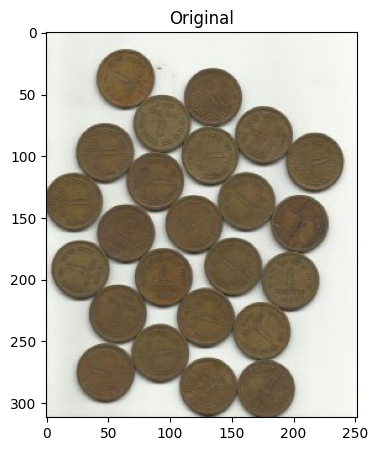

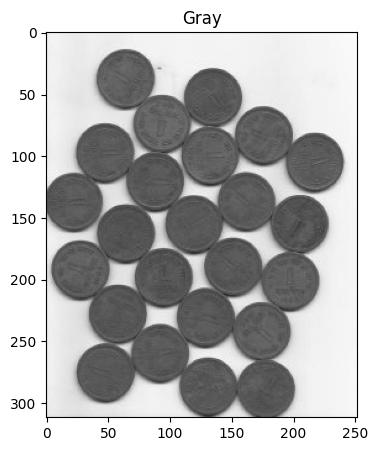

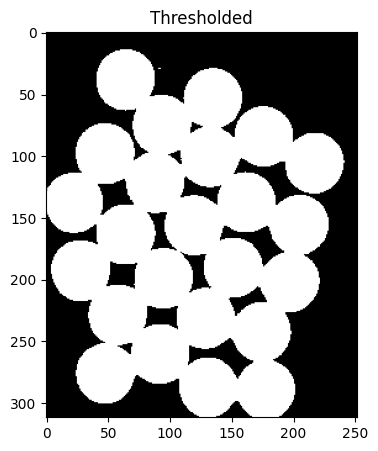

In [24]:
image= cv2.imread('images/water_coins.jpg')
imshow(image, 'Original', 5)

gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(gray, 'Gray', 5)

ret, thresh= cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
imshow(thresh, 'Thresholded', 5)

In [5]:
image.dtype, type(image)

(dtype('uint8'), numpy.ndarray)

## **Removing the touching masks**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..23.968996].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


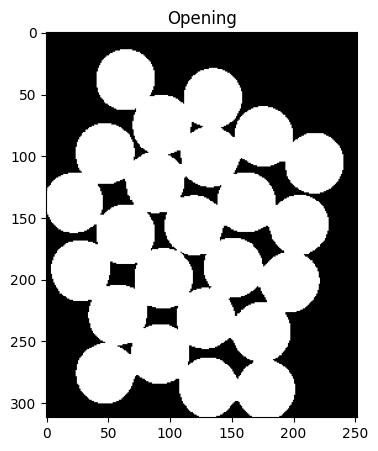

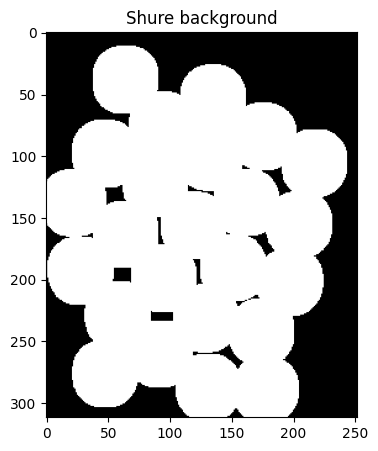

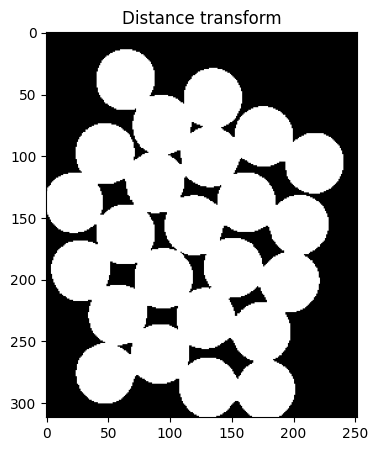

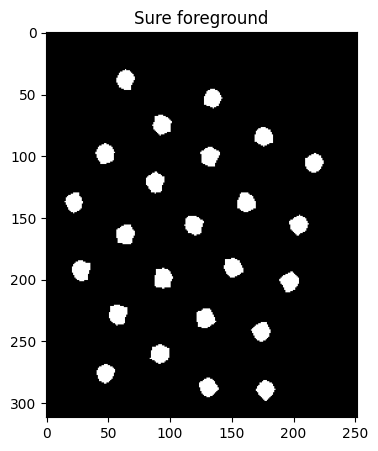

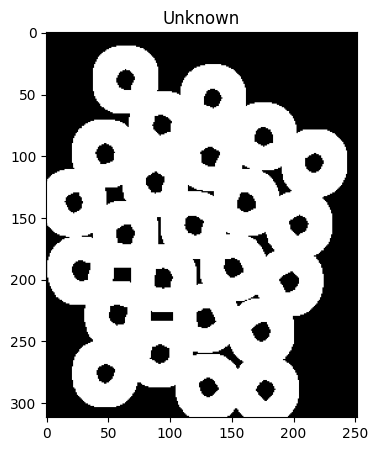

In [6]:
# noise removal
kernel= np.ones((3,3))
opening= cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
imshow(opening, 'Opening', 5)

# sure background area
sure_bg= cv2.dilate(opening, kernel, iterations=3)
imshow(sure_bg, 'Shure background', 5)

# Finding sure foreground area
dist_transform= cv2.distanceTransform(opening, cv2.DIST_L2, maskSize=5)
imshow(dist_transform, 'Distance transform', 5)

ret, sure_fg= cv2.threshold(dist_transform, dist_transform.max()*0.7, 255, cv2.THRESH_BINARY)
imshow(sure_fg, 'Sure foreground', 5)

# Finding unknown region
sure_fg= np.uint8(sure_fg)
unknown= cv2.subtract(sure_bg, sure_fg)
imshow(unknown, 'Unknown', 5)

In [248]:
thresh.shape

(312, 252)

In [249]:
kernel

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [250]:
opening.shape

(312, 252)

In [251]:
sure_bg.shape

(312, 252)

In [252]:
dist_transform.shape

(312, 252)

In [253]:
sure_fg.shape

(312, 252)

In [254]:
sure_bg.dtype, sure_fg.dtype

(dtype('uint8'), dtype('uint8'))

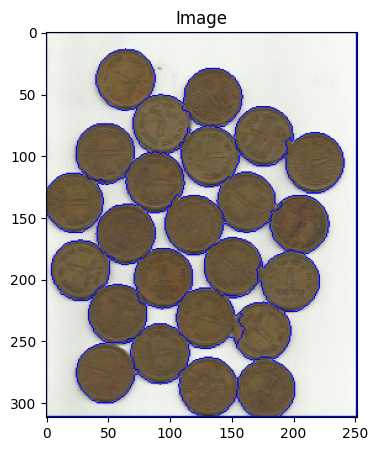

In [32]:
# Marker labelling
# Connected Components determines the connectivity of blob-like regions in a binary image.
ret, markers= cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers+=1

# Now, mark the region of unknown with zero
markers[unknown==255]= 0

markers= cv2.watershed(image, markers)
image[markers==-1]= [255,0,0]

imshow(image, 'Image', 5)


In [166]:
ret

25

In [167]:
markers.shape, markers[0,:10]

((312, 252), array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int32))

In [168]:
sure_fg[0,:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [169]:
markers[unknown==255]

array([ 1,  1,  1, ..., -1, -1, -1], dtype=int32)

In [170]:
sure_fg[unknown==255]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [171]:
np.unique(markers)

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32)

In [172]:
np.unique(image)

array([  0,  22,  25,  26,  27,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20

In [206]:
image.dtype, type(image)

(dtype('uint8'), numpy.ndarray)

In [219]:
(image[markers==1])

array([[234, 241, 238],
       [237, 244, 241],
       [237, 244, 241],
       ...,
       [241, 246, 244],
       [241, 246, 244],
       [241, 246, 244]], dtype=uint8)